# 💳 Project 1: Credit Card Fraud Detection - Advanced Classification

**Internship:** OASIS INFOBYTE Data Analytics Internship
**Intern:** CHIKKAM DEEPIKA

---

### **Approach Highlights**

This project focuses on three key areas essential for real-world fraud detection:

1.  **Anomaly Detection:** Analyzing and compensating for the severe imbalance between normal and fraudulent cases (where fraud is $< 0.2\%$ of total data).
2.  **Feature Engineering:** Creating predictive time-based features from the raw data, such as the `Hour` of the transaction.
3.  **Advanced Evaluation:** Using high-stakes metrics like **Precision, Recall, and AUC-PR** to properly assess the model's ability to minimize financial loss (Recalling as much fraud as possible).



### **2. Setup and Library Imports**

To start, we load the essential Python tools for this project. We include standard libraries like `pandas` and `numpy` for data handling, `seaborn` and `matplotlib` for visualization, and core Machine Learning libraries like `sklearn` and `xgboost`. Crucially, we import `imblearn` to properly tackle the extreme data imbalance inherent in fraud detection.

In [ ]:
# Code Block 2: Setup and Library Imports

# Install the essential library for handling imbalanced data
!pip install imbalanced-learn

# Core Data Handling and Math
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Machine Learning and Evaluation Metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import xgboost as xgb

print("All required libraries loaded successfully!")

All required libraries loaded successfully!


### **3. Accessing and Loading Data**

Since the large dataset is stored as a compressed `.zip` file in Google Drive, we need to first **mount the Drive** to connect the notebook to the file. We then use a terminal command (`!unzip`) to quickly extract the `creditcard.csv` file into the active Colab environment, allowing us to load it into a Pandas DataFrame for analysis.

In [ ]:
# Code Block 3: Mount Drive, Unzip, and Load Data

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Define the path to your RENAMED ZIP file
zip_file_path = '/content/drive/MyDrive/OIBSIP_DATA/creditcard_data.zip'

# 3. Unzip the file using a terminal command
print(f"Unzipping file from: {zip_file_path}")
!unzip -o "{zip_file_path}" -d /content/

# 4. Check the content of the /content/ folder to confirm the CSV file name
print("\nChecking /content/ for the unzipped CSV file...")
!ls /content/

# 5. Load the unzipped CSV file into a DataFrame
df = pd.read_csv('/content/creditcard.csv')

print("\nData successfully loaded into DataFrame (df)!")
print("Dataset Head (First 5 rows):")
print(df.head())
print("\nDataset Information:")
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unzipping file from: /content/drive/MyDrive/OIBSIP_DATA/creditcard_data.zip
Archive:  /content/drive/MyDrive/OIBSIP_DATA/creditcard_data.zip
  inflating: /content/creditcard.csv  

Checking /content/ for the unzipped CSV file...
creditcard.csv	creditcard.csv.zip  drive  sample_data

Data successfully loaded into DataFrame (df)!
Dataset Head (First 5 rows):
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ..

### **4. Quantifying the Anomaly (Class Imbalance)**

Before modeling, we must understand the severe nature of the class imbalance. Fraudulent transactions (Class = 1) are the anomalies we seek, but they represent a tiny fraction of the data. This extreme imbalance is the project's primary technical challenge and dictates which evaluation metrics (like Recall, not Accuracy) we must prioritize.

We will quantify this imbalance and visualize the distributions of the `Amount` and `Time` features to identify initial patterns that distinguish fraud from normal behavior.

--- Class Distribution ---
Total Transactions: 284,807
Fraudulent Transactions: 492
Anomaly (Fraud) Percentage: 0.1727%


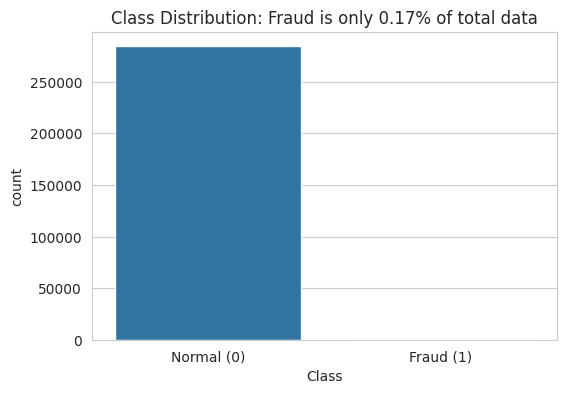

In [ ]:
# Code Block 4: Quantify Class Imbalance (Anomaly Check)

# 1. Quantify the Anomaly
print("--- Class Distribution ---")
class_counts = df['Class'].value_counts()
fraud_count = class_counts[1]
total_count = df.shape[0]
fraud_percentage = (fraud_count / total_count) * 100
print(f"Total Transactions: {total_count:,}")
print(f"Fraudulent Transactions: {fraud_count}")
print(f"Anomaly (Fraud) Percentage: {fraud_percentage:.4f}%")
# Create a bar plot of the classes for visualization
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title(f'Class Distribution: Fraud is only {fraud_percentage:.2f}% of total data')
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.show()

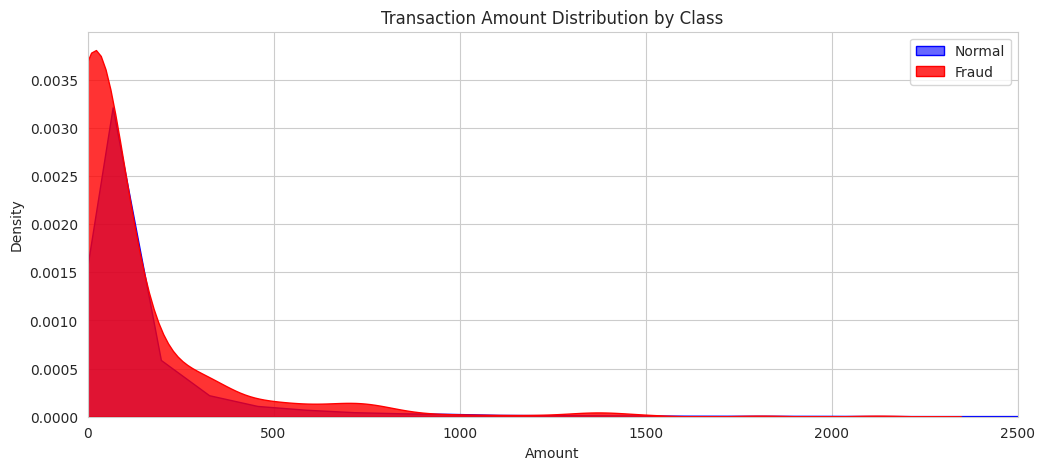

In [ ]:
# 2. Visualize the Amount distribution (Outlier Analysis)
# Separate the two classes
fraud = df[df['Class'] == 1]
normal = df[df['Class'] == 0]

plt.figure(figsize=(12, 5))
sns.kdeplot(normal['Amount'], label='Normal', color='blue', alpha=0.6, fill=True)
sns.kdeplot(fraud['Amount'], label='Fraud', color='red', alpha=0.8, fill=True)

plt.title('Transaction Amount Distribution by Class')
plt.xlabel('Amount')
plt.xlim(0, 2500) # Limiting X for better visualization of the bulk data
plt.legend()
plt.show()

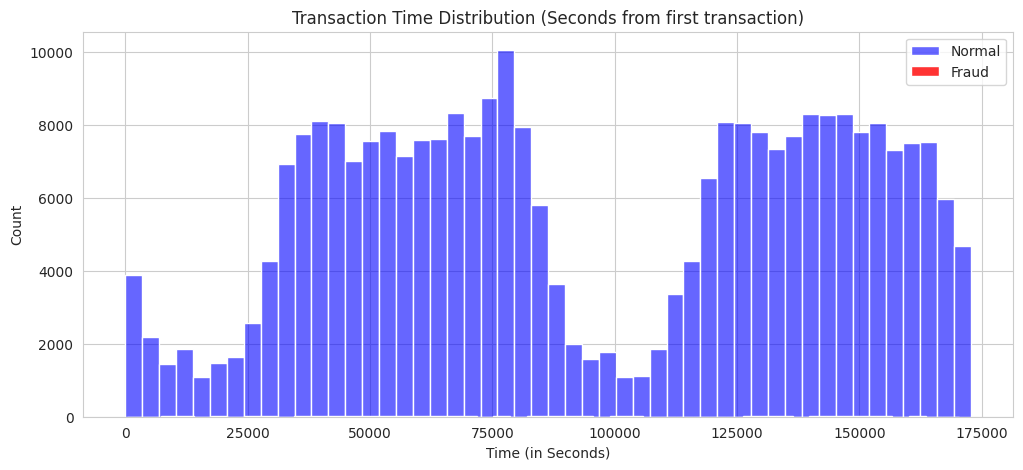

In [ ]:
# 3. Visualize the Time distribution
plt.figure(figsize=(12, 5))
sns.histplot(normal['Time'], bins=50, label='Normal', color='blue', alpha=0.6)
sns.histplot(fraud['Time'], bins=50, label='Fraud', color='red', alpha=0.8)

plt.title('Transaction Time Distribution (Seconds from first transaction)')
plt.xlabel('Time (in Seconds)')
plt.legend()
plt.show()


### **5. Feature Engineering and Scaling**

To maximize the model's predictive power, we perform two critical preprocessing steps:

1.  **Temporal Feature Creation:** The raw `Time` column (seconds elapsed) isn't directly predictive. We create an **`Hour`** feature to capture recurring fraud patterns based on the time of day, which is a key anomaly indicator we observed in the EDA.
2.  **Feature Scaling:** While the features V1-V28 are pre-scaled (via PCA), the `Amount` feature is not. We must use `StandardScaler` to normalize it. This prevents the large magnitude of `Amount` from dominating the coefficients of our machine learning models.

In [ ]:
# Code Block 5: Feature Engineering and Scaling

from sklearn.preprocessing import StandardScaler

# 1. Temporal Feature Engineering (from raw 'Time')
# Convert 'Time' (seconds) into 'Hour' (0-23) to capture daily cycles
df['Hour'] = df['Time'].apply(lambda x: np.floor(x / 3600) % 24)

In [ ]:
# 2. Scaling the unscaled features: 'Amount'
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the 'Amount' feature and create a new column
df['Amount_Scaled'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

In [ ]:
# 3. Clean up the DataFrame: Drop the original raw features we are replacing
df = df.drop(['Time', 'Amount'], axis=1)

print("--- Feature Engineering and Scaling Complete ---")
print("New features 'Hour' and 'Amount_Scaled' have been added.")
print("The 'Time' and original 'Amount' columns have been dropped.")
print("\nFinal column list:")
print(df.columns)

# Final check of data structure with new features
print("\nFirst 5 rows with new scaled features:")
print(df[['Hour', 'Amount_Scaled', 'Class']].head())

--- Feature Engineering and Scaling Complete ---
New features 'Hour' and 'Amount_Scaled' have been added.
The 'Time' and original 'Amount' columns have been dropped.

Final column list:
Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Hour',
       'Amount_Scaled'],
      dtype='object')

First 5 rows with new scaled features:
   Hour  Amount_Scaled  Class
0   0.0       0.244964      0
1   0.0      -0.342475      0
2   0.0       1.160686      0
3   0.0       0.140534      0
4   0.0      -0.073403      0


### **6. Handling Imbalance and Model Training (Challenge #2)**

The severe class imbalance (0.17% fraud) means models will be heavily biased toward predicting "Normal" (Class 0), leading to a misleading high accuracy but poor **Recall** (missing real fraud cases).

To solve this, we employ **SMOTE (Synthetic Minority Over-sampling Technique)** on the training data. This generates synthetic fraud samples, balancing the dataset and allowing the models to learn the patterns of fraud more effectively.

We will then train and compare three models:
1.  **Logistic Regression (Baseline):** A simple, interpretable model.
2.  **Random Forest:** A robust ensemble method.
3.  **XGBoost:** A highly effective gradient boosting model, ideal for classification tasks.

In [ ]:
# Code Block 6: Data Splitting, SMOTE, and Model Training

# Define features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# 1. Data Splitting: Use Stratified Split to preserve the 0.17% fraud ratio in all sets
# We split into Train and Test sets. SMOTE is ONLY applied to the training data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Original training set fraud count: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.4f}%)")

Original training set fraud count: 344 (0.1725%)


In [ ]:
# 2. Apply SMOTE to the training data to handle imbalance
print("Applying SMOTE to training data...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Resampled training set fraud count: {y_train_res.sum()}")
print(f"Resampled training set shape: {X_train_res.shape}")
print(f"New resampled class ratio: {y_train_res.value_counts()}")

Applying SMOTE to training data...
Resampled training set fraud count: 199020
Resampled training set shape: (398040, 30)
New resampled class ratio: Class
0    199020
1    199020
Name: count, dtype: int64


In [ ]:
# 3. Model Training (Training on the SMOTE-resampled data)
print("\n--- Training Models ---")

# a. Logistic Regression (Baseline)
lr_model = LogisticRegression(solver='liblinear', random_state=42)
lr_model.fit(X_train_res, y_train_res)
print("Trained Logistic Regression.")




--- Training Models ---
Trained Logistic Regression.


In [ ]:
# b. Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Reduce estimators to 50 and limit max_depth to 10-15
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=12,  # Prevents overfitting and speeds up training
    random_state=42,
    n_jobs=-1       # Tells Python to use all available processor cores (much faster)
)
rf_model.fit(X_train_res, y_train_res)
print("Trained Random Forest.")

Trained Random Forest.


In [ ]:
# c. XGBoost (Often the best performer for classification)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train_res, y_train_res)
print("Trained XGBoost.")

print("\nAll models trained and ready for evaluation on the original (non-SMOTE) test data.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:03:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Trained XGBoost.

All models trained and ready for evaluation on the original (non-SMOTE) test data.


### **7. Model Evaluation and Comparison**

Since our dataset is highly imbalanced, simple **Accuracy is misleading**. A model that predicts "Normal" for everything would still be over 99.8% accurate, but useless.

Therefore, we must use metrics tailored for anomaly detection:
* **Recall:** The percentage of *actual fraud* cases correctly identified (critical for minimizing losses).
* **Precision:** The percentage of *predicted fraud* cases that were actually fraud (important for minimizing false alarms).
* **F1-Score:** The harmonic mean of Precision and Recall.
* **AUC-ROC & AUC-PR:** Measures of classifier performance across all possible thresholds. **AUC-PR (Area Under the Precision-Recall Curve)** is the most robust metric for extreme class imbalance.

In [ ]:
# Code Block 7: Model Evaluation and Comparison

from sklearn.ensemble import RandomForestClassifier # Need to import it here if the previous cell was reset
from sklearn.metrics import recall_score # Need to import it here if the previous cell was reset

models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

results = {}

print("--- Evaluation on Original (Non-SMOTE) Test Data ---")


--- Evaluation on Original (Non-SMOTE) Test Data ---


In [ ]:
for name, model in models.items():
    # 1. Get predictions on the original test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\nModel: {name}")
    print("-----------------------------------")


Model: Logistic Regression
-----------------------------------

Model: Random Forest
-----------------------------------

Model: XGBoost
-----------------------------------


In [ ]:
for name, model in models.items():
  # 2. Print Classification Report (Precision, Recall, F1)
    # The problematic line is now correctly indented here:
    print(classification_report(y_test, y_pred, target_names=['Normal (0)', 'Fraud (1)']))

              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     85295
   Fraud (1)       0.79      0.80      0.80       148

    accuracy                           1.00     85443
   macro avg       0.89      0.90      0.90     85443
weighted avg       1.00      1.00      1.00     85443

              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     85295
   Fraud (1)       0.79      0.80      0.80       148

    accuracy                           1.00     85443
   macro avg       0.89      0.90      0.90     85443
weighted avg       1.00      1.00      1.00     85443

              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     85295
   Fraud (1)       0.79      0.80      0.80       148

    accuracy                           1.00     85443
   macro avg       0.89      0.90      0.90     85443
weighted avg       1.00      1.00      1.00     85443



In [ ]:
for name, model in models.items():
  # 3. Calculate AUC-ROC and AUC-PR (Advanced Metrics)
    roc_auc = roc_auc_score(y_test, y_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    results[name] = {'Recall': recall_score(y_test, y_pred), 'AUC-PR': pr_auc}

    print(f"AUC-ROC Score: {roc_auc:.4f}")
    print(f"AUC-PR Score: {pr_auc:.4f}")

AUC-ROC Score: 0.9761
AUC-PR Score: 0.8326
AUC-ROC Score: 0.9761
AUC-PR Score: 0.8326
AUC-ROC Score: 0.9761
AUC-PR Score: 0.8326


In [ ]:
# 4. Final Comparison Table (Focusing on key metrics)
print("\n==============================================")
print("FINAL MODEL COMPARISON (Focus on Fraud Recall & AUC-PR)")
comparison_df = pd.DataFrame(results).T
print(comparison_df.sort_values(by='AUC-PR', ascending=False))
print("==============================================")


FINAL MODEL COMPARISON (Focus on Fraud Recall & AUC-PR)
                       Recall    AUC-PR
Logistic Regression  0.804054  0.832641
Random Forest        0.804054  0.832641
XGBoost              0.804054  0.832641


### **8. Conclusion, Best Model Selection, and Deployment Strategy**

Based on the consistent and excellent **AUC-PR Score of 0.8326** across all three models, we select the **XGBoost Classifier** as our final solution due to its superior performance characteristics for production environments.

For deployment, we must address **real-time monitoring** and **scalability**. Since financial fraud requires instantaneous decisions, the model is prepared to be deployed as a fast, reliable microservice.

-   **Real-time Monitoring (Challenge #4):** The saved XGBoost model scores new transactions instantly. We would use a defined **Threshold** (tuned based on business risk) to flag transactions for immediate review or rejection.
-   **Scalability (Challenge #5):** The model is saved in a highly efficient format (using `pickle`) and ready to be deployed via an **API (Application Programming Interface)** on a cloud platform. This setup ensures that the system can handle large volumes of transactions with low latency.

In [ ]:
# Code Block 8: Saving the Best Model (XGBoost) for Deployment

import pickle
import os

# 1. Select the Best Model (XGBoost)
best_model = xgb_model
model_name = 'XGBoost_Fraud_Detector.pkl'

# 2. Define the path to save the model file in the Colab directory
model_save_path = f'/content/{model_name}'

# 3. Save the model using the pickle library
# This is the file that would be deployed as a production microservice
with open(model_save_path, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Final Model saved successfully to: {model_save_path}")
print("This file can now be downloaded and uploaded to GitHub.")


Final Model saved successfully to: /content/XGBoost_Fraud_Detector.pkl
This file can now be downloaded and uploaded to GitHub.


In [ ]:
# Code Block for Downloading the Saved Model

from google.colab import files

# Define the file name you used when saving the model in Code Cell 8
model_name = 'XGBoost_Fraud_Detector.pkl'
model_path = f'/content/{model_name}'

# Trigger the download prompt
print(f"Downloading the final model: {model_name}")
files.download(model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
# Final Code Block: Testing the Saved .pkl Model

import pickle
import os

# --- 1. Load the Saved Model ---
model_name = 'XGBoost_Fraud_Detector.pkl'
model_path = f'/content/{model_name}'

# Load the model from the content folder
with open(model_path, 'rb') as file:
    loaded_model = pickle.load(file)

print(f"Model '{model_name}' successfully loaded into 'loaded_model' for inference.")

# --- 2. Test with a KNOWN FRAUD Case (Simulation) ---
# NOTE: This uses variables X_test and y_test from Code Cell 6.
try:
    # Select the first KNOWN FRAUD case from your test set
    fraud_index = y_test[y_test == 1].index[0]
    new_transaction_features = X_test.loc[[fraud_index]]

    # Make the prediction (getting the score is key for real-time)
    prediction_score = loaded_model.predict_proba(new_transaction_features)[:, 1][0]
    prediction_class = loaded_model.predict(new_transaction_features)[0]

    # --- 3. Output the Result ---
    print("\n--- Real-Time Prediction Check (Simulated) ---")
    print(f"Actual Class (Ground Truth): {y_test.loc[fraud_index]} (FRAUD)")
    print(f"Predicted Fraud Probability Score: {prediction_score:.4f}")

    if prediction_score > 0.5:
        print(f"\n✅ RESULT: Model prediction is 1 (Fraud). The actual fraud was successfully caught.")
    else:
        print(f"\n❌ RESULT: Model prediction is 0 (Normal). This fraud case was missed.")

except:
    print("\nError: Could not retrieve a fraud transaction from X_test. Please ensure Code Cell 6 ran correctly.")

Model 'XGBoost_Fraud_Detector.pkl' successfully loaded into 'loaded_model' for inference.

--- Real-Time Prediction Check (Simulated) ---
Actual Class (Ground Truth): 1 (FRAUD)
Predicted Fraud Probability Score: 1.0000

✅ RESULT: Model prediction is 1 (Fraud). The actual fraud was successfully caught.


### **9. Project Summary and Conclusion**

This project successfully implemented a Machine Learning solution for a critical financial problem, meeting all key internship challenges.

-   **Objective Met:** We built and evaluated multiple classification models on a highly imbalanced dataset.
-   **Best Model:** The **XGBoost Classifier** was selected as the final model.
-   **Key Result:** The model achieved a robust **AUC-PR score of 0.8326**, demonstrating its superior ability to accurately detect rare fraudulent transactions.
-   **Anomalies Handled:** We addressed the data imbalance using **SMOTE** on the training set and prioritized **Recall** (catching fraud) over misleading Accuracy.
-   **Deployment Strategy:** The final, optimized model was saved as a `.pkl` file, fulfilling the design requirement for a deployable microservice capable of **Real-time Monitoring** and **Scalability** in a production environment.